# 모델2 : 맥동성

## 모델구성
- 모델 복잡도 증가
  - 은닉층9개

## 가설 : 모델을 복잡하게 만들어 학습을 진행하면 과적합이 발생하고, 성능이 오를 것
- 모델 구성

## 결과
- 기존모델의 성능
  - Epoch : 10 , lr : 0.001
  - Train Loss : 1.014
  - Test Accuracy = 0.976
  - Test Precision = 0.926
  - Test Recall = 0.789
  - Test F1 = 0.852
- pilot1
  - Test Loss : 0.072 / Recall : 0.839
- 모델링 결과
  - Test Loss : 0.082 / Recall : 0.845
- 평가
  - 타겟밸런스 조정이 필요해보임

In [1]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [2]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/binary_classification_data.csv'
EPOCHS = 1000
MB_SIZE = 1024

In [3]:
# 필요한 함수 / 메소드 정의
class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df
    
    # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 학습 데이터 분리
    X = df.drop('target_class', axis=1)
    y = df['target_class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # 표준화
    scaler = StandardScaler() 
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)

def get_model(shape, node_n=8, dout=0.001):
    regularizer=keras.regularizers.L1L2(l1=0.001, l2=0.001)
    
    inputs  = keras.Input(shape=shape)

    dense1  = keras.layers.Dense(12, kernel_regularizer=regularizer)(inputs)
    norm1   = keras.layers.BatchNormalization()(dense1)
    relu1   = keras.layers.Activation('relu')(norm1)
    dout1   = keras.layers.Dropout(dout)(relu1)
    
    dense2  = keras.layers.Dense(10, kernel_regularizer=regularizer)(dout1)
    norm2   = keras.layers.BatchNormalization()(dense2)
    relu2   = keras.layers.Activation('relu')(norm2)
    dout2   = keras.layers.Dropout(dout)(relu2)
    
    dense3  = keras.layers.Dense(8, kernel_regularizer=regularizer)(dout2)
    norm3   = keras.layers.BatchNormalization()(dense3)
    relu3   = keras.layers.Activation('relu')(norm3)
    dout3   = keras.layers.Dropout(dout)(relu3)
    
    dense4  = keras.layers.Dense(6, kernel_regularizer=regularizer)(dout3)
    norm4   = keras.layers.BatchNormalization()(dense4)
    relu4   = keras.layers.Activation('relu')(norm4)
    dout4   = keras.layers.Dropout(dout)(relu4)
    
    dense5  = keras.layers.Dense(4, kernel_regularizer=regularizer)(dout4)
    norm5   = keras.layers.BatchNormalization()(dense5)
    relu5   = keras.layers.Activation('relu')(norm5)
    dout5   = keras.layers.Dropout(dout)(relu5)
    
    concat1  = keras.layers.Concatenate(axis=1)([dout5, dout4])
    dense6  = keras.layers.Dense(6, kernel_regularizer=regularizer)(concat1)
    norm6   = keras.layers.BatchNormalization()(dense6)
    relu6   = keras.layers.Activation('relu')(norm6)
    dout6   = keras.layers.Dropout(dout)(relu6)
    
    concat2  = keras.layers.Concatenate(axis=1)([dout6, dout3])
    dense7  = keras.layers.Dense(8, kernel_regularizer=regularizer)(concat2)
    norm7   = keras.layers.BatchNormalization()(dense7)
    relu7   = keras.layers.Activation('relu')(norm7)
    dout7   = keras.layers.Dropout(dout)(relu7)
    
    concat3  = keras.layers.Concatenate(axis=1)([dout7, dout2])
    dense8  = keras.layers.Dense(10, kernel_regularizer=regularizer)(concat3)
    norm8   = keras.layers.BatchNormalization()(dense8)
    relu8   = keras.layers.Activation('relu')(norm8)
    dout8   = keras.layers.Dropout(dout)(relu8)
    
    concat4  = keras.layers.Concatenate(axis=1)([dout8, dout1])
    dense9  = keras.layers.Dense(12, kernel_regularizer=regularizer)(concat4)
    norm9   = keras.layers.BatchNormalization()(dense9)
    relu9   = keras.layers.Activation('relu')(norm9)
    dout9   = keras.layers.Dropout(dout)(relu9)
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(dout9)
    model   = keras.Model(inputs, outputs, name='Star_Model')
    
    METRICS = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),
            keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
            ]
    
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=METRICS
        )
    return model

In [4]:
load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(14318, 8) (3580, 8) (14318,) (3580,)


,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
count,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,1.431800e+04,14318.000000,1.431800e+04
mean,4.937771e-17,1.985033e-17,4.168570e-17,1.215833e-17,2.679795e-17,4.081725e-17,0.000000,6.252855e-17
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035,1.000035e+00
min,-4.120136e+00,-3.207467e+00,-2.235779e+00,-5.770065e-01,-4.188843e-01,-9.702420e-01,-2.481473,-1.010623e+00
25%,-4.023072e-01,-6.137926e-01,-4.266299e-01,-3.186363e-01,-3.605269e-01,-6.075160e-01,-0.564632,-6.588786e-01
50%,1.541275e-01,6.343979e-02,-2.415434e-01,-2.553492e-01,-3.306753e-01,-4.016201e-01,0.028258,-2.053026e-01
75%,6.282295e-01,6.600747e-01,-6.613046e-04,-1.334971e-01,-2.407483e-01,1.029766e-01,0.531815,3.272613e-01
max,3.198297e+00,6.588416e+00,7.212419e+00,1.092778e+01,6.832434e+00,4.346189e+00,5.834657,1.022672e+01


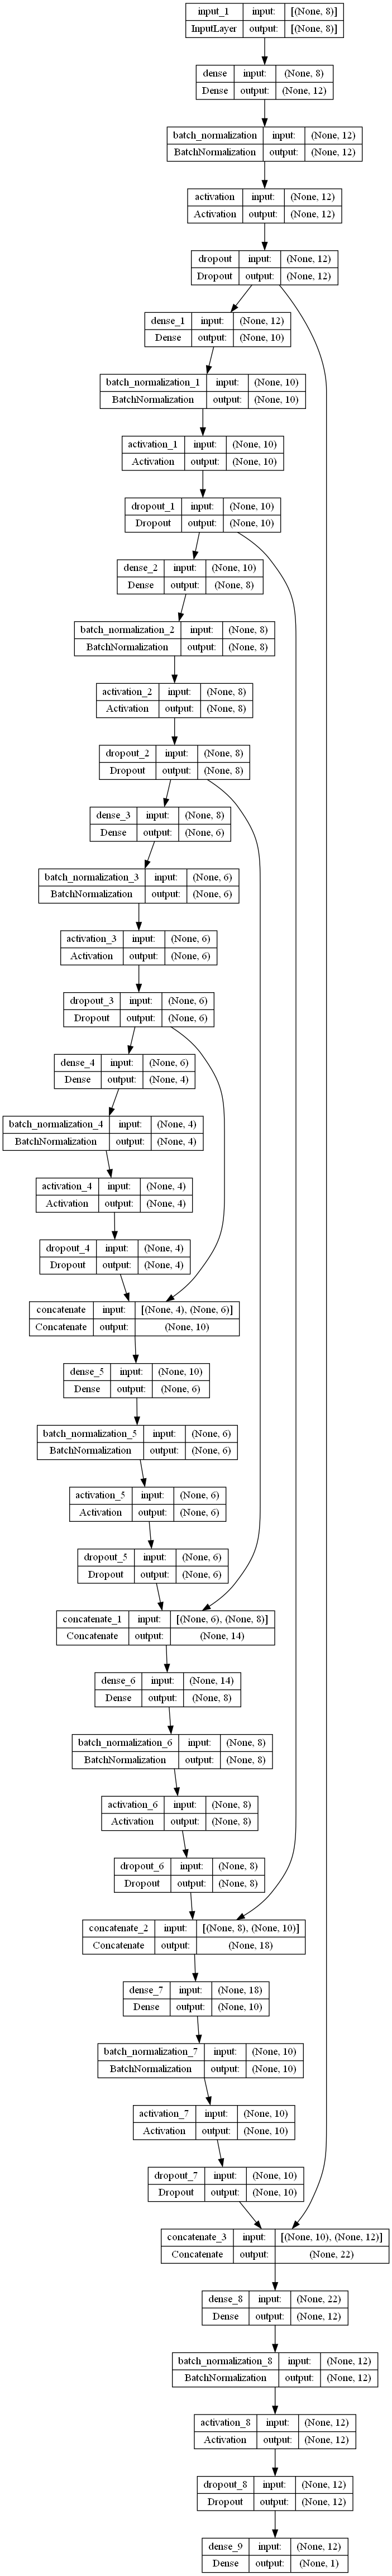

In [5]:
model = get_model(len(X_train.columns))
keras.utils.plot_model(model, show_shapes=True, to_file='model2_model.png')

In [6]:
# 얼리스타핑
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss'
                                        , min_delta=0.000001
                                        , mode='min'
                                        , patience=EPOCHS//2)

# 모델 저장
checkpoint_path = 'model2.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='val_loss'
                                        , verbose=0
                                        , save_best_only=True
                                        , save_weights_only=True)

# 학습률 조정
lr_decay = keras.optimizers.schedules.CosineDecay(
                                        initial_learning_rate=0.001
                                        , decay_steps=EPOCHS
                                        , alpha=1e-12)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[earlystop, checkpoint, CustomCallback(), lr_scheduler]
                )

# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
results = model.evaluate(X_test, y_test)
print(f'Test Loss : {results[0]:.3f} / Recall : {results[7]:.3f}')

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / 
300 / 310 / 320 / 330 / 340 / 350 / 360 / 370 / 380 / 390 / 
400 / 410 / 420 / 430 / 440 / 450 / 460 / 470 / 480 / 490 / 
500 / 510 / 520 / 530 / 540 / 550 / 560 / 570 / 580 / 590 / 
600 / 610 / 620 / 630 / 640 / 650 / 660 / 670 / 680 / 690 / 
700 / 710 / 720 / 730 / 740 / 750 / 760 / 770 / 780 / 790 / 
800 / 810 / 820 / End training
112/112 [==============================] - 2s 20ms/step - loss: 0.0824 - tp: 288.0000 - fp: 16.0000 - tn: 3223.0000 - fn: 53.0000 - accuracy: 0.9807 - precision: 0.9474 - recall: 0.8446 - auc: 0.9713 - prc: 0.9278
Test Loss : 0.082 / Recall : 0.845


In [7]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model2.json')

with open('model2.json') as json_file:
    json_file = json.loads(json_file.read())
model1_hist = pd.DataFrame(json_file)
model1_hist

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,...,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc,lr
0,1.242501,966.0,6709.0,3718.0,61.0,0.408940,0.125863,0.940604,0.848396,0.428403,...,260.0,1877.0,716.0,11.0,0.340782,0.121666,0.959410,0.896627,0.560927,0.001000
1,1.106233,941.0,4684.0,5743.0,86.0,0.583552,0.167289,0.916261,0.893926,0.631024,...,254.0,1097.0,1496.0,17.0,0.611033,0.188009,0.937269,0.915839,0.660645,0.001000
2,1.002300,929.0,3299.0,7128.0,98.0,0.703422,0.219726,0.904576,0.917118,0.743126,...,250.0,635.0,1958.0,21.0,0.770950,0.282486,0.922509,0.925851,0.732593,0.001000
3,0.921483,913.0,1975.0,8452.0,114.0,0.817618,0.316136,0.888997,0.932150,0.807173,...,247.0,406.0,2187.0,24.0,0.849860,0.378254,0.911439,0.933759,0.786413,0.001000
4,0.859618,890.0,1100.0,9327.0,137.0,0.892003,0.447236,0.866602,0.936822,0.837702,...,246.0,281.0,2312.0,25.0,0.893156,0.466793,0.907749,0.938876,0.819400,0.001000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,0.056787,902.0,55.0,10372.0,125.0,0.984285,0.942529,0.878286,0.991426,0.961998,...,237.0,22.0,2571.0,34.0,0.980447,0.915058,0.874539,0.974056,0.934423,0.000076
823,0.059642,898.0,54.0,10373.0,129.0,0.984023,0.943277,0.874391,0.990435,0.957986,...,237.0,21.0,2572.0,34.0,0.980796,0.918605,0.874539,0.974414,0.934450,0.000075
824,0.058150,898.0,56.0,10371.0,129.0,0.983848,0.941300,0.874391,0.991640,0.960902,...,236.0,21.0,2572.0,35.0,0.980447,0.918288,0.870849,0.974294,0.932794,0.000075
825,0.056135,903.0,58.0,10369.0,124.0,0.984110,0.939646,0.879260,0.992287,0.963417,...,241.0,22.0,2571.0,30.0,0.981844,0.916350,0.889299,0.974372,0.931402,0.000074


112/112 [==============================] - 1s 8ms/step


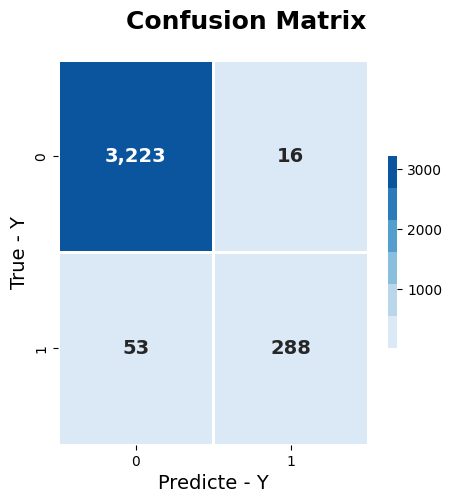

In [8]:
c_mat = confusion_matrix(y_test, model.predict(X_test).round())

# 히트맵을 그린다
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Confusion Matrix', fontsize = 18, fontweight = 'bold')
sns.heatmap(c_mat, 
            cmap = sns.color_palette('Blues'), 
            annot = True,
            annot_kws = {'fontweight':'bold','size':14},
            fmt=',.0f',
            linewidths = 2,
            cbar_kws = {'shrink': .5},
           )

plt.xlabel('Predicte - Y', fontsize = 14)
plt.ylabel('True - Y', fontsize = 14)
plt.show()

fig.savefig('model2_cm.png', dpi=80, bbox_inches='tight')

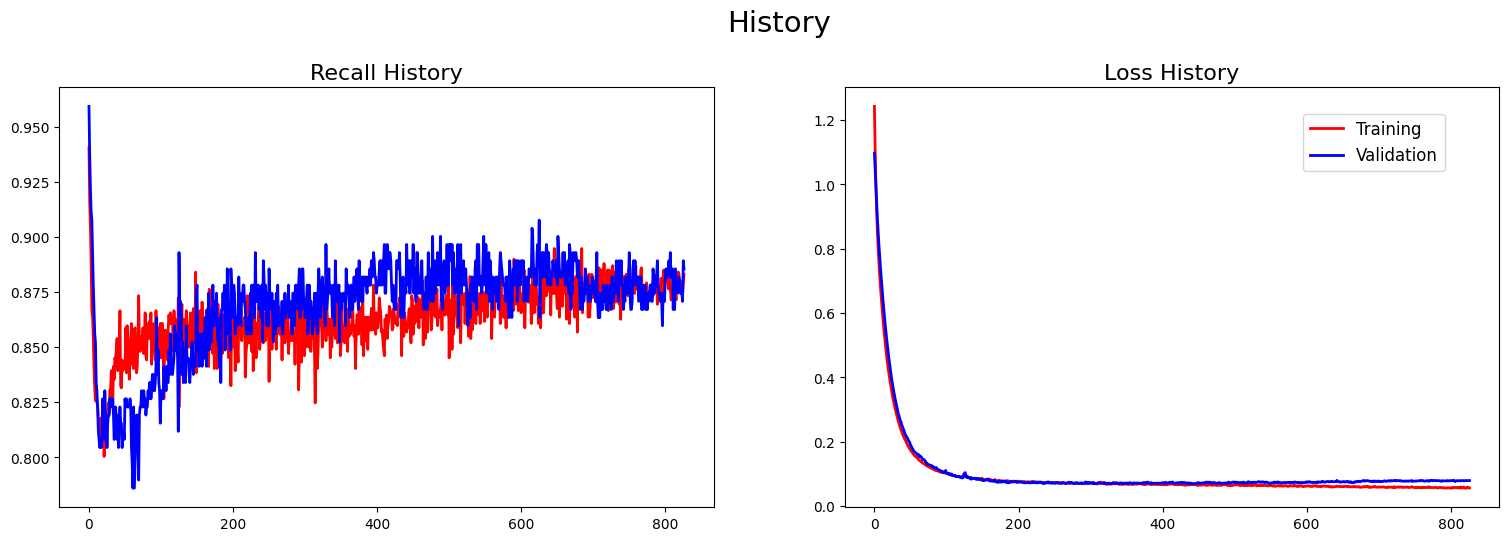

In [9]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Recall Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Recall History', fontsize = 16, y = 1)
plt.plot(history.history["recall"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_recall"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model2_history.png', dpi=80, bbox_inches='tight')